In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import time
from benchmarkUtils import Benchmark

In [2]:
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", None)

TESTING = False
TESTING_SIZE = 0.01
random_state = 245
benchmark_util = Benchmark(iter_n=10)

In [3]:
def test_train_val_split(df, random_state=random_state):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
# if IN_COLAB:
#     prepend_path = (
#         "/content/drive/MyDrive/Syncable/sjsu/data-245/DATA 245 Project Files/data"
#     )
# else:
#     prepend_path = "./data"
prepend_path = "./data"
known_attacks_path = f"{prepend_path}/probe_known_attacks_small.csv"
similar_attacks_path = f"{prepend_path}/probe_similar_attacks_small.csv"
new_attacks_path = f"{prepend_path}/probe_new_attacks_small.csv"

In [5]:
df = pd.read_csv(known_attacks_path, low_memory=False)

In [6]:
if TESTING:
    df = df.sample(frac=TESTING_SIZE, random_state=random_state)
    df.reset_index(drop=True, inplace=True)
df.shape

(85060, 51)

In [7]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_offset', 'ip_RF', 'ip_DF', 'ip_MF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [8]:
df.head()

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0,552,13968,0,0,0,0,6,49165,0,0,0,0,0,0,0,80,54640,2925601313,2784850843,0,0,0,0,1,0,512,6,416,579,416,579,5121,65535,5121,65535,1,0,0,0,0,0,415,579,1,1,0,0,0,0,normal
1,0,552,13969,0,0,0,0,6,49164,0,0,0,0,0,0,0,80,54640,2925601825,2784850843,0,0,0,0,1,0,512,6,416,580,416,580,5121,65535,5121,65535,1,0,0,0,0,0,415,580,1,1,0,0,0,0,normal
2,0,40,25941,0,0,0,0,6,44274,0,0,0,0,0,0,0,58502,80,0,394780220,0,0,0,0,1,0,6,1,1,0,1,0,6,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,attack
3,0,52,56525,0,0,1,0,6,56195,0,0,0,0,0,0,0,56069,80,7130052,2926006578,0,0,0,0,1,0,12,6,31,37,31,37,500,16916,500,16916,1,0,0,0,0,0,30,37,1,1,0,0,0,0,normal
4,0,52,27415,0,0,1,0,6,19834,0,0,0,0,0,0,0,54640,80,2784850843,2925599265,0,0,0,0,1,0,12,6,417,580,417,580,5133,65535,5133,65535,1,0,0,0,0,0,416,580,1,1,0,0,0,0,normal


In [9]:
df.describe(include="all")

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
count,85060.000000,85060.000000,85060.000000,85060.0,85060.0,85060.000000,85060.0,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,8.506000e+04,8.506000e+04,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48432
mean,0.754667,100.386174,31165.699577,0.0,0.0,0.363931,0.0,8.039925,33087.734246,7335.142699,4493.626499,7.966353,6440.783964,0.062168,0.054456,620.470245,27821.129226,13938.420973,1.471971e+09,1.008449e+09,0.553903,0.568152,0.527980,0.486151,0.913884,0.473360,65.945121,5.869821,405.885857,520.797084,328.958617,291.029732,10105.989772,28114.899694,8279.352187,17662.463144,40.784376,44.620327,36.238349,74.642147,83.044075,19.918340,162.481060,265.684047,113.913144,30.737621,37.778486,140.026957,0.003492,0.089560,NaN
std,5.925130,191.572060,19906.379891,0.0,0.0,0.481132,0.0,4.450021,18710.567547,17846.337785,13369.749481,21.495346,15363.667022,0.491994,0.400504,4495.728132,24382.931287,20878.971872,1.419588e+09,1.377824e+09,0.820632,0.819572,0.821924,0.822284,0.710662,0.821969,190.189264,4.249343,1235.773115,1367.500610,1956.456315,1413.383988,17353.336438,41288.108509,17651.159114,29433.799558,1117.698208,1485.625396,786.401261,1124.563326,1294.569237,968.524034,1637.743817,1173.387641,1556.568989,1363.660077,1310.832438,666.280141,0.058987,0.285552,NaN
min,0.000000,28.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,40.000000,14018.000000,0.0,0.0,0.000000,0.0,6.000000,16980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,80.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,39.000000,38.000000,5.000000,2.000000,813.000000,18.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,52.000000,31076.500000,0.0,0.0,0.000000,0.0,6.000000,34049.500000,0.000000

It seems as though ip_RF, ip_MF, and ip_offset do not contain any valuable information. They can be removed

In [10]:
df = df.drop(columns=["ip_RF", "ip_MF", "ip_offset"])

In [11]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_DF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [12]:
print(df["class"].value_counts())
print(df["class"].value_counts(normalize=True) * 100)

class
normal    48432
attack    36628
Name: count, dtype: int64
class
normal    56.938632
attack    43.061368
Name: proportion, dtype: float64


In [13]:
df.dtypes

ip_type                    int64
ip_len                     int64
ip_id                      int64
ip_DF                      int64
ip_proto                   int64
ip_checksum                int64
udp_sport                  int64
udp_dport                  int64
udp_len                    int64
udp_chk                    int64
icmp_type                  int64
icmp_code                  int64
icmp_chk                   int64
tcp_sport                  int64
tcp_dport                  int64
tcp_seq                    int64
tcp_ack                    int64
tcp_ffyn                   int64
tcp_fsyn                   int64
tcp_frst                   int64
tcp_fpush                  int64
tcp_fack                   int64
tcp_furg                   int64
fr_length                  int64
conn_status                int64
count_fr_src_dst           int64
count_fr_dst_src           int64
count_serv_src_dst         int64
count_serv_dst_src         int64
num_bytes_src_dst          int64
num_bytes_

In [14]:
df["ip_type"].value_counts()

ip_type
0      83516
40      1528
192       16
Name: count, dtype: int64

In [15]:
df["class"] = df["class"].replace({"normal": 0, "attack": 1})

In [16]:
df = df.astype(float)

In [17]:
corr = df.corr()

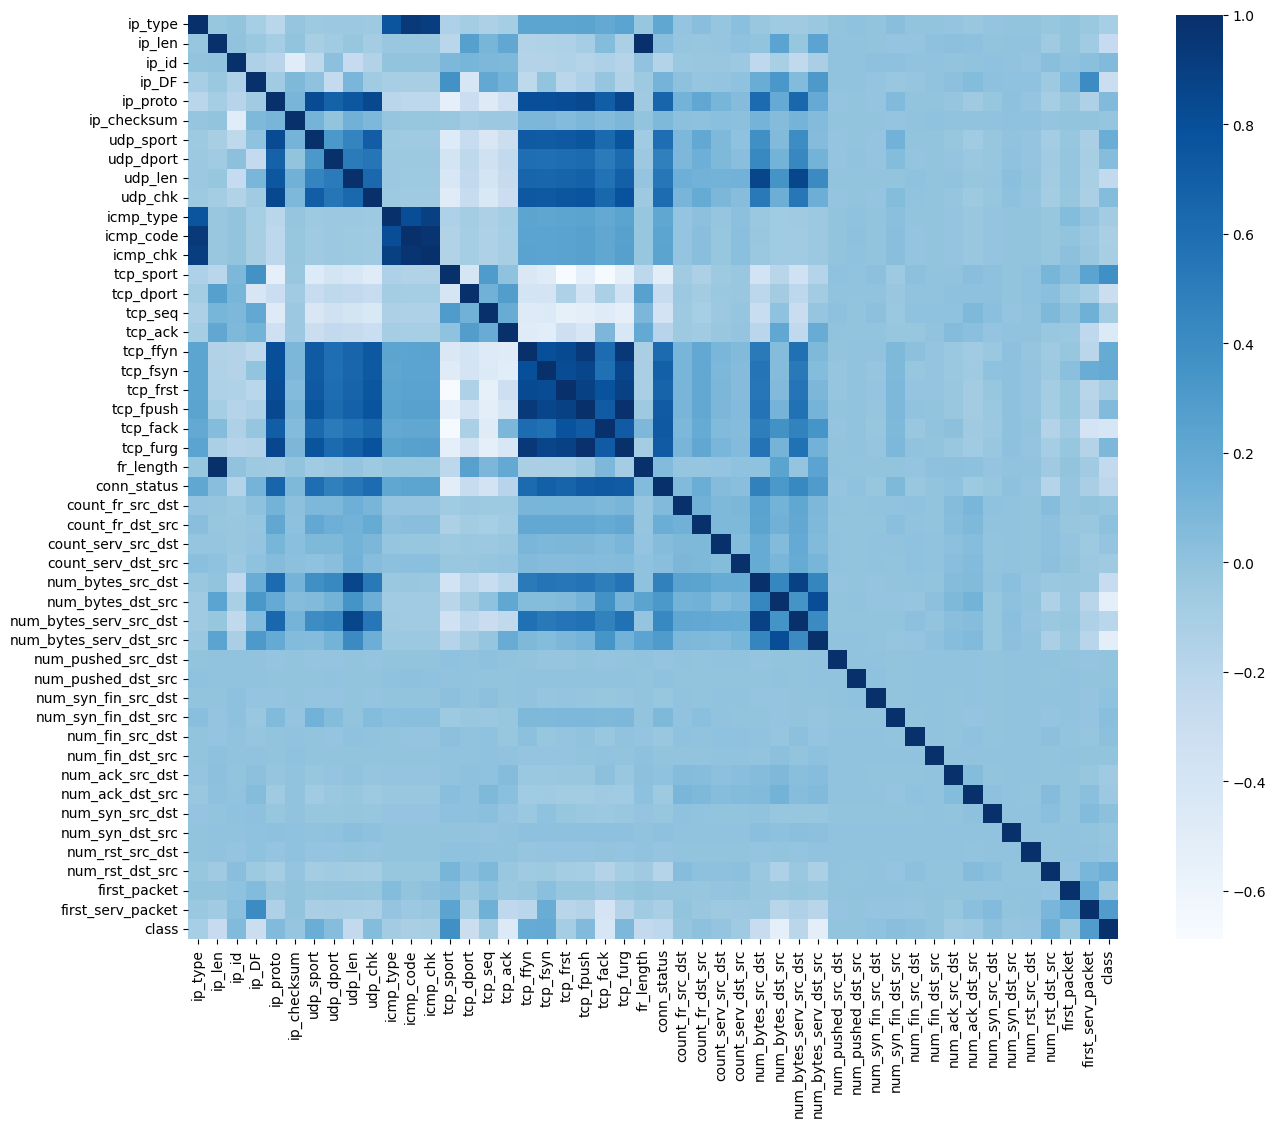

In [18]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="Blues")
plt.show()

In [19]:
corr["class"].sort_values(ascending=False)

class                     1.000000
tcp_sport                 0.376711
first_serv_packet         0.288401
tcp_fsyn                  0.183862
tcp_ffyn                  0.179369
udp_sport                 0.159150
num_rst_dst_src           0.148479
tcp_furg                  0.081623
ip_id                     0.070370
ip_proto                  0.068846
tcp_fpush                 0.068064
udp_chk                   0.050838
udp_dport                 0.043169
num_syn_fin_dst_src       0.032562
num_syn_src_dst           0.023503
num_fin_src_dst           0.018179
count_fr_dst_src          0.016557
num_syn_fin_src_dst       0.010139
num_pushed_src_dst       -0.005405
num_pushed_dst_src       -0.006834
num_fin_dst_src          -0.008403
num_rst_src_dst          -0.008925
count_serv_src_dst       -0.010181
ip_checksum              -0.015762
num_syn_dst_src          -0.017306
count_fr_src_dst         -0.018505
first_packet             -0.032560
num_ack_dst_src          -0.042007
num_ack_src_dst     

The target feature does not seem to have very strong correlations with any particular feature.

In [20]:
# remove all features with an absolute correlation of less than 0.1
cols_corr_gt1 = corr["class"][abs(corr["class"]) > 0.1].index

In [21]:
print(cols_corr_gt1)
print(len(cols_corr_gt1))

Index(['ip_len', 'ip_DF', 'udp_sport', 'udp_len', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_fack', 'fr_length', 'conn_status', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_rst_dst_src', 'first_serv_packet', 'class'], dtype='object')
21


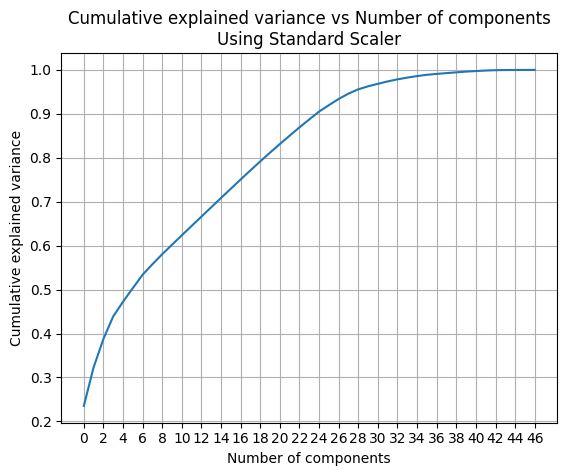

In [22]:
X = df.drop(columns=["class"])

scaler_standard = StandardScaler()
X_scaled = scaler_standard.fit_transform(X)

pca_standard = PCA(n_components=len(df.columns) - 1)
X_pca = pca_standard.fit_transform(X_scaled)

pca_cumsum = pca_standard.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components\nUsing Standard Scaler")
plt.grid()
plt.xticks(range(0, len(df.columns) - 1, 2))
plt.show()

In [23]:
print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")

at n=28, we have 95% of the variance explained


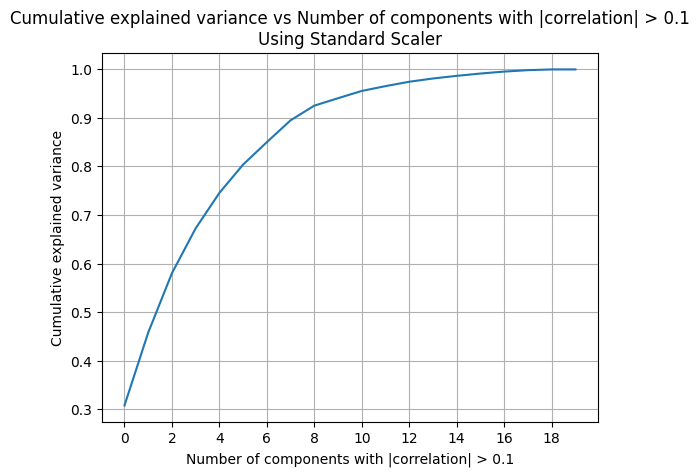

In [24]:
X_gt1 = df[cols_corr_gt1]
X_gt1 = X_gt1.drop(columns=["class"])

scaler_standard_gt1 = StandardScaler()
X_gt1_scaled = scaler_standard_gt1.fit_transform(X_gt1)

pca_corr_gt1_standard = PCA(n_components=len(cols_corr_gt1) - 1)
X_gt1_pca = pca_corr_gt1_standard.fit_transform(X_gt1_scaled)

pca_cumsum = pca_corr_gt1_standard.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components with |correlation| > 0.1")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components with |correlation| > 0.1\nUsing Standard Scaler")
plt.grid()
plt.xticks(range(0, len(cols_corr_gt1) - 1, 2))
plt.show()

In [25]:
print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")

at n=10, we have 95% of the variance explained


# Modelling

In [26]:
_, _, __X__, _, _, __y__ = test_train_val_split(df)
df_known_attacks = pd.DataFrame(__X__)
df_known_attacks["class"] = __y__
df_known_attacks.reset_index(drop=True, inplace=True)

In [27]:
df_similar_attacks = pd.read_csv(similar_attacks_path, low_memory=False)
df_similar_attacks = df_similar_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_similar_attacks["class"] = df_similar_attacks["class"].replace({"normal": 0, "attack": 1})

df_new_attacks = pd.read_csv(new_attacks_path, low_memory=False)
df_new_attacks = df_new_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_new_attacks["class"] = df_new_attacks["class"].replace({"normal": 0, "attack": 1})

In [28]:
if TESTING:
    df_similar_attacks = df_similar_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_similar_attacks.reset_index(drop=True, inplace=True)
    df_new_attacks = df_new_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_new_attacks.reset_index(drop=True, inplace=True)

In [29]:
def pipeline_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs:
        raise ValueError("df and scaler must be passed as keyword arguments for pipeline_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=df.columns[:-1])
    df_["class"] = df["class"]
    return df_

In [30]:
def pipeline_corr_gt1_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs:
        raise ValueError("df, scaler, and cols must be passed as keyword arguments for pipeline_corr_gt1_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=cols[:-1])
    df_["class"] = df["class"]
    return df_

In [31]:
def pipeline_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, and pca must be passed as keyword arguments for pipeline_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    pca = kwargs["pca"]
    pca_cols = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :pca_cols]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

In [32]:
def pipeline_corr_gt1_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, cols, and pca must be passed as keyword arguments for pipeline_corr_gt1_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]
    pca = kwargs["pca"]
    pca_cols = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]


    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :pca_cols]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

In [33]:
df_scaled = pipeline_scaled(df=df, scaler=scaler_standard)
df_scaled.head()

,ip_type,ip_len,ip_id,ip_DF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,-0.127368,2.357424,-0.863934,-0.756411,-0.458411,0.859266,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,-1.137734,1.949417,1.023986,1.289289,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,2.345335,0.030635,0.008185,0.042562,0.044490,0.203746,-0.287266,0.906322,-0.178933,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154188,0.267020,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
1,-0.127368,2.357424,-0.863884,-0.756411,-0.458411,0.859213,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,-1.137734,1.949417,1.023987,1.289289,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,2.345335,0.030635,0.008185,0.043293,0.044490,0.204454,-0.287266,0.906322,-0.178933,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154188,0.267872,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
2,-0.127368,-0.315216,-0.262465,-0.756411,-0.458411,0.597862,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.258300,-0.663754,-1.036906,-0.445392,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.315189,-1.146024,-0.327640,-0.380841,-0.167630,-0.205911,-0.582023,-0.680948,-0.468717,-0.600078,-0.036490,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,-0.098600,-0.226426,-0.073183,-0.022541,-0.02882,-0.210164,16.893706,3.188363,1.0
3,-0.127368,-0.252576,1.273936,1.322033,-0.458411,1.234992,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.158517,-0.663754,-1.031884,1.391738,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.283641,0.030635,-0.303363,-0.353784,-0.152296,-0.179733,-0.553556,-0.271239,-0.440730,-0.025361,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,-0.080893,-0.194893,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
4,-0.127368,-0.252576,-0.188418,1.322033,-0.458411,-0.708360,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.099910,-0.663754,0.924837,1.391442,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.283641,0.030635,0.008994,0.043293,0.045001,0.204454,-0.286574,0.906322,-0.178253,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154799,0.267872,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0


In [34]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [35]:
df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1)
df_corr_gt1_scaled.head()

,ip_len,ip_DF,udp_sport,udp_len,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_fack,fr_length,conn_status,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_rst_dst_src,first_serv_packet,class
0,2.357424,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,-1.137734,1.949417,1.289289,-0.674975,-0.693234,0.121177,2.345335,0.030635,-0.287266,0.906322,-0.178933,1.626457,-0.210164,-0.313641,0.0
1,2.357424,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,-1.137734,1.949417,1.289289,-0.674975,-0.693234,0.121177,2.345335,0.030635,-0.287266,0.906322,-0.178933,1.626457,-0.210164,-0.313641,0.0
2,-0.315216,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,1.258300,-0.663754,-0.445392,-0.674975,-0.693234,0.121177,-0.315189,-1.146024,-0.582023,-0.680948,-0.468717,-0.600078,-0.210164,3.188363,1.0
3,-0.252576,1.322033,-0.411019,-0.37061,-0.135969,-0.138014,1.158517,-0.663754,1.391738,-0.674975,-0.693234,0.121177,-0.283641,0.030635,-0.553556,-0.271239,-0.440730,-0.025361,-0.210164,-0.313641,0.0
4,-0.252576,1.322033,-0.411019,-0.37061,-0.135969,-0.138014,1.099910,-0.663754,1.391442,-0.674975,-0.693234,0.121177,-0.283641,0.030635,-0.286574,0.906322,-0.178253,1.626457,-0.210164,-0.313641,0.0


In [36]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_val,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_val,
    y_corr_gt1_scaled_test,
) = test_train_val_split(df_corr_gt1_scaled)

In [37]:
df_pca = pipeline_pca(df=df, scaler=scaler_standard, pca=pca_standard)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,class
0,-1.516735,-1.070537,4.199741,-1.394049,0.957756,0.583451,1.314415,0.300038,-0.100427,-0.074686,0.018951,-0.068260,-0.085588,-0.029476,-0.045298,0.029734,0.115908,0.130896,-0.111055,-0.021935,-0.102228,0.114430,0.068183,-0.159354,0.227031,-0.697531,0.338713,0.248599,0.0
1,-1.516680,-1.070594,4.199846,-1.393880,0.957351,0.583922,1.314396,0.300622,-0.100220,-0.074792,0.018950,-0.068254,-0.085581,-0.029455,-0.045232,0.029740,0.115972,0.130898,-0.111276,-0.022129,-0.102981,0.114281,0.068581,-0.159547,0.227155,-0.697391,0.338751,0.248571,0.0
2,-2.194275,0.599526,-2.547375,1.784875,4.735872,2.335350,-1.259882,0.229815,-6.911835,-8.327002,-2.483018,0.013701,-2.341332,-1.531040,-0.593786,1.307459,5.735253,2.203422,1.863483,0.821762,-1.594002,-2.386889,2.089085,8.092894,1.559132,0.200839,-1.005800,0.331981,1.0
3,-1.795953,-0.176684,-0.057415,0.785596,-0.009620,-1.722739,-0.344424,0.030185,0.169341,0.000372,-0.112997,-0.017776,-0.066358,0.030031,-0.103921,-0.081910,-0.207825,-0.091106,0.108699,0.166714,-0.022175,-0.519474,0.144395,0.563761,-0.508144,1.405539,0.976435,-0.170937,0.0
4,-1.698577,-0.885367,1.251274,1.889236,-0.672711,-1.345817,-0.983839,0.260147,0.271514,0.089606,-0.036208,-0.054843,0.004780,-0.013959,-0.135784,-0.008889,-0.014911,0.071884,-0.026465,0.074480,-0.111767,-0.359301,0.286965,0.171620,-0.189821,-0.418918,-0.024381,-0.276469,0.0


In [38]:
(
    X_pca_train,
    X_pca_val,
    X_pca_test,
    y_pca_train,
    y_pca_val,
    y_pca_test,
) = test_train_val_split(df_pca)

In [39]:
df_corr_gt1_pca = pipeline_corr_gt1_pca(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1_standard)
df_corr_gt1_pca.head()

,0,1,2,3,4,5,6,7,8,9,class
0,-0.543609,4.230357,1.869249,-0.251843,0.788871,0.190714,0.364347,-0.114097,0.499856,-0.081331,0.0
1,-0.543609,4.230357,1.869249,-0.251843,0.788871,0.190714,0.364347,-0.114097,0.499856,-0.081331,0.0
2,-1.994167,-1.461920,-0.938954,0.293926,1.364275,-0.010223,0.649041,-0.738695,-0.118310,0.030188,1.0
3,-1.350594,0.261992,-0.964845,1.102809,-0.889646,-1.028780,-0.107525,0.580810,-1.068071,0.201405,0.0
4,-0.704318,1.340008,-1.522401,1.729258,-1.340019,-0.612810,-0.126361,0.481897,0.016040,-0.037508,0.0


In [40]:
(
    X_corr_gt1_pca_train,
    X_corr_gt1_pca_val,
    X_corr_gt1_pca_test,
    y_corr_gt1_pca_train,
    y_corr_gt1_pca_val,
    y_corr_gt1_pca_test,
) = test_train_val_split(df_corr_gt1_pca)

## SVM

### All features scaled

In [41]:
svm_scaled = SVC(**{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}, random_state=random_state)
svm_scaled.fit(X_scaled_train, y_scaled_train)

SVC(C=100, random_state=245)

In [42]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [43]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        svm_scaled,
        "SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 12759
Accuracy: 0.997570342503331
Precision: 0.9971176364618988
Recall: 0.9972972972972973
F1: 0.9972074587874966
Time per data per iter: 518.729681


In [44]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_scaled,
        "SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       0.99      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 26409
Accuracy: 0.9904577984777917
Precision: 0.994659157117887
Recall: 0.9811302681992338
F1: 0.9878483942520976
Time per data per iter: 1037.2630334


In [45]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        svm_scaled,
        "SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.66      0.01      0.02     17752

    accuracy                           0.77     75890
   macro avg       0.71      0.50      0.44     75890
weighted avg       0.74      0.77      0.67     75890


Model: SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 75890
Accuracy: 0.7671366451442878
Precision: 0.65625
Recall: 0.00946372239747634
F1: 0.018658374055975122
Time per data per iter: 2984.3067799


### Features with |correlation| > 0.1 scaled

In [46]:
svm_corr_gt1_scaled = SVC(**{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}, random_state=random_state)
svm_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

SVC(C=1000, random_state=245)

In [47]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        svm_corr_gt1_scaled,
        "SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7209
         1.0       1.00      0.99      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 12759
Accuracy: 0.9957676933928992
Precision: 0.9971056439942113
Recall: 0.9931531531531531
F1: 0.9951254739122586
Time per data per iter: 362.8911428


In [48]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_corr_gt1_scaled,
        "SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 26409
Accuracy: 0.9890188950736492
Precision: 0.9975490196078431
Recall: 0.9746168582375478
F1: 0.9859496124031009
Time per data per iter: 749.0637479


In [49]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        svm_corr_gt1_scaled,
        "SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.38      0.00      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.57      0.50      0.44     75890
weighted avg       0.68      0.77      0.67     75890


Model: SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 75890
Accuracy: 0.7656212939781263
Precision: 0.3825503355704698
Recall: 0.0032109058134294727
F1: 0.00636835930953578
Time per data per iter: 2147.5150645999997


### All features with 95% PCA

In [50]:
svm_pca = SVC(**{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, random_state=random_state)
svm_pca.fit(X_pca_train, y_pca_train)

SVC(C=100, gamma='auto', random_state=245)

In [51]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        svm_pca,
        "SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 12759
Accuracy: 0.9968649580688141
Precision: 0.9955035971223022
Recall: 0.9972972972972973
F1: 0.9963996399639964
Time per data per iter: 689.6470952999999


In [52]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_pca,
        "SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 26409
Accuracy: 0.9910636525426938
Precision: 0.9968835216205687
Recall: 0.9804597701149426
F1: 0.988603438284721
Time per data per iter: 1514.0536825


In [53]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        svm_pca,
        "SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.62      0.01      0.02     17752

    accuracy                           0.77     75890
   macro avg       0.69      0.50      0.44     75890
weighted avg       0.73      0.77      0.67     75890


Model: SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 75890
Accuracy: 0.7668203979443932
Precision: 0.6196581196581197
Recall: 0.00816809373591708
F1: 0.01612365172912265
Time per data per iter: 3798.1916195


### Features with |correlation| > 0.1 with 95% PCA

In [54]:
svm_corr_gt1_pca = SVC(**{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}, random_state=random_state)
svm_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

SVC(C=1000, gamma='auto', random_state=245)

In [55]:
print(classification_report(y_corr_gt1_pca_test, svm_corr_gt1_pca.predict(X_corr_gt1_pca_test)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7209
         1.0       1.00      0.99      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [56]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        svm_corr_gt1_pca,
        "SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7209
         1.0       1.00      0.99      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 12759
Accuracy: 0.9964730778274159
Precision: 0.9985509871400109
Recall: 0.9933333333333333
F1: 0.9959353265287688
Time per data per iter: 428.1901944


In [57]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_corr_gt1_pca,
        "SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 26409
Accuracy: 0.988602370404029
Precision: 0.9993105486063233
Recall: 0.9718390804597701
F1: 0.9853833827028602
Time per data per iter: 830.6234297999999


In [58]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        svm_corr_gt1_pca,
        "SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.59      0.00      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.68      0.50      0.44     75890
weighted avg       0.72      0.77      0.67     75890


Model: SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 75890
Accuracy: 0.7663855580445381
Precision: 0.5864661654135338
Recall: 0.004393871113114015
F1: 0.008722393066815767
Time per data per iter: 2294.048158


## Gaussian Naive Bayes

### All features scaled

In [59]:
gnb_scaled = GaussianNB(**{'var_smoothing': 1.519911082952933e-07})
gnb_scaled.fit(X_scaled_train, y_scaled_train)

GaussianNB(var_smoothing=1.519911082952933e-07)

In [60]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_scaled,
        "GaussianNB {'var_smoothing': 1.519911082952933e-07}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81      7209
         1.0       0.71      0.99      0.83      5550

    accuracy                           0.82     12759
   macro avg       0.85      0.84      0.82     12759
weighted avg       0.87      0.82      0.82     12759


Model: GaussianNB {'var_smoothing': 1.519911082952933e-07}
Data size: 12759
Accuracy: 0.8173838075084254
Precision: 0.7068876895399641
Recall: 0.9911711711711712
F1: 0.8252325232523252
Time per data per iter: 9.916843


In [61]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_scaled,
        "GaussianNB {'var_smoothing': 1.519911082952933e-07}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     15969
           1       0.66      0.99      0.79     10440

    accuracy                           0.79     26409
   macro avg       0.82      0.83      0.79     26409
weighted avg       0.86      0.79      0.80     26409


Model: GaussianNB {'var_smoothing': 1.519911082952933e-07}
Data size: 26409
Accuracy: 0.7948426672725207
Precision: 0.6610647851186658
Recall: 0.9871647509578544
F1: 0.7918555512869765
Time per data per iter: 19.1947635


In [62]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_scaled,
        "GaussianNB {'var_smoothing': 1.519911082952933e-07}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.79      0.82      0.80     58138
           1       0.31      0.27      0.29     17752

    accuracy                           0.69     75890
   macro avg       0.55      0.54      0.55     75890
weighted avg       0.68      0.69      0.68     75890


Model: GaussianNB {'var_smoothing': 1.519911082952933e-07}
Data size: 75890
Accuracy: 0.6913427329028857
Precision: 0.3133473739634066
Recall: 0.26819513294276703
F1: 0.28901839373520305
Time per data per iter: 50.2949524


### Features with |correlation| > 0.1 scaled

In [63]:
gnb_corr_gt1_scaled = GaussianNB(**{'var_smoothing': 4.328761281083053e-06})
gnb_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

GaussianNB(var_smoothing=4.328761281083053e-06)

In [64]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_corr_gt1_scaled,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82      7209
         1.0       0.72      0.99      0.83      5550

    accuracy                           0.83     12759
   macro avg       0.86      0.85      0.83     12759
weighted avg       0.87      0.83      0.82     12759


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 12759
Accuracy: 0.8260051728191865
Precision: 0.7158973029045643
Recall: 0.9947747747747748
F1: 0.8326044337204043
Time per data per iter: 4.6966607


In [65]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_corr_gt1_scaled,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     15969
           1       0.67      0.99      0.80     10440

    accuracy                           0.81     26409
   macro avg       0.83      0.84      0.81     26409
weighted avg       0.87      0.81      0.81     26409


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 26409
Accuracy: 0.805672308682646
Precision: 0.6718911917098446
Recall: 0.9936781609195402
F1: 0.8017001545595053
Time per data per iter: 7.9887782000000005


In [66]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_corr_gt1_scaled,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     58138
           1       0.32      0.25      0.28     17752

    accuracy                           0.70     75890
   macro avg       0.55      0.54      0.55     75890
weighted avg       0.68      0.70      0.69     75890


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 75890
Accuracy: 0.6996969297667677
Precision: 0.31934882386689617
Recall: 0.2508449752140604
F1: 0.2809818273599193
Time per data per iter: 28.3544155


### All features with 95% PCA

In [67]:
gnb_pca = GaussianNB(**{'var_smoothing': 4.328761281083053e-06})
gnb_pca.fit(X_pca_train, y_pca_train)

GaussianNB(var_smoothing=4.328761281083053e-06)

In [68]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_pca,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77      7209
         1.0       0.67      0.99      0.80      5550

    accuracy                           0.79     12759
   macro avg       0.83      0.81      0.78     12759
weighted avg       0.85      0.79      0.78     12759


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 12759
Accuracy: 0.7855631319068892
Precision: 0.6716691068814056
Recall: 0.9918918918918919
F1: 0.800960279353994
Time per data per iter: 15.768047


In [69]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_pca,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.98      0.61      0.76     15969
           1       0.62      0.98      0.76     10440

    accuracy                           0.76     26409
   macro avg       0.80      0.80      0.76     26409
weighted avg       0.84      0.76      0.76     26409


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 26409
Accuracy: 0.7600060585406491
Precision: 0.6247415156307019
Recall: 0.9839080459770115
F1: 0.7642288520199391
Time per data per iter: 30.440379399999998


In [70]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_pca,
        "GaussianNB {'var_smoothing': 4.328761281083053e-06}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     58138
           1       0.38      0.71      0.50     17752

    accuracy                           0.66     75890
   macro avg       0.63      0.68      0.62     75890
weighted avg       0.76      0.66      0.69     75890


Model: GaussianNB {'var_smoothing': 4.328761281083053e-06}
Data size: 75890
Accuracy: 0.6643563051785479
Precision: 0.38287413521058383
Recall: 0.710793150067598
F1: 0.4976729510136468
Time per data per iter: 83.339836


### Features with |correlation| > 0.1 with 95% PCA

In [71]:
gnb_corr_gt1_pca = GaussianNB(**{'var_smoothing': 0.0005336699231206307})
gnb_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

GaussianNB(var_smoothing=0.0005336699231206307)

In [72]:
print(classification_report(y_corr_gt1_pca_test, gnb_corr_gt1_pca.predict(X_corr_gt1_pca_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      7209
         1.0       0.92      0.93      0.92      5550

    accuracy                           0.93     12759
   macro avg       0.93      0.93      0.93     12759
weighted avg       0.93      0.93      0.93     12759



In [73]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_corr_gt1_pca,
        "GaussianNB {'var_smoothing': 0.0005336699231206307}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      7209
         1.0       0.92      0.93      0.92      5550

    accuracy                           0.93     12759
   macro avg       0.93      0.93      0.93     12759
weighted avg       0.93      0.93      0.93     12759


Model: GaussianNB {'var_smoothing': 0.0005336699231206307}
Data size: 12759
Accuracy: 0.9345559996864958
Precision: 0.922718307333692
Recall: 0.9272072072072072
F1: 0.9249573110452054
Time per data per iter: 12.798575900000001


In [74]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_corr_gt1_pca,
        "GaussianNB {'var_smoothing': 0.0005336699231206307}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     15969
           1       0.94      0.98      0.96     10440

    accuracy                           0.97     26409
   macro avg       0.96      0.97      0.97     26409
weighted avg       0.97      0.97      0.97     26409


Model: GaussianNB {'var_smoothing': 0.0005336699231206307}
Data size: 26409
Accuracy: 0.9686849180203718
Precision: 0.9428729383580576
Recall: 0.9801724137931035
F1: 0.9611609449114732
Time per data per iter: 22.165475100000002


In [75]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_corr_gt1_pca,
        "GaussianNB {'var_smoothing': 0.0005336699231206307}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     58138
           1       0.73      0.19      0.30     17752

    accuracy                           0.79     75890
   macro avg       0.76      0.58      0.59     75890
weighted avg       0.78      0.79      0.74     75890


Model: GaussianNB {'var_smoothing': 0.0005336699231206307}
Data size: 75890
Accuracy: 0.793371985768876
Precision: 0.7291436158442133
Recall: 0.18561288868859846
F1: 0.2959004984059988
Time per data per iter: 41.3118332


In [76]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


## Logistic Regression

### All features scaled

In [77]:
log_scaled = LogisticRegression(**{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}, random_state=random_state)
log_scaled.fit(X_scaled_train, y_scaled_train)

LogisticRegression(C=1, penalty='l1', random_state=245, solver='liblinear')

In [78]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        log_scaled,
        "Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7209
         1.0       0.99      0.99      0.99      5550

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759


Model: Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 12759
Accuracy: 0.9933380358962302
Precision: 0.9899587591895285
Recall: 0.9947747747747748
F1: 0.9923609238788532
Time per data per iter: 6.336827


In [79]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        log_scaled,
        "Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     15969
           1       1.00      0.95      0.97     10440

    accuracy                           0.98     26409
   macro avg       0.98      0.98      0.98     26409
weighted avg       0.98      0.98      0.98     26409


Model: Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 26409
Accuracy: 0.9800446817372865
Precision: 0.9951053840775147
Recall: 0.9542145593869732
F1: 0.9742310889443059
Time per data per iter: 18.706266


In [80]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        log_scaled,
        "Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.85      0.04      0.08     17752

    accuracy                           0.77     75890
   macro avg       0.81      0.52      0.48     75890
weighted avg       0.79      0.77      0.69     75890


Model: Logistic Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 75890
Accuracy: 0.7744762155751745
Precision: 0.8450704225352113
Recall: 0.04393871113114015
F1: 0.08353413654618473
Time per data per iter: 36.033333


In [81]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 scaled

In [82]:
log_corr_gt1_scaled = LogisticRegression(**{'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}, random_state=random_state)
log_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

/home/ibrahim/pyenv_sjsu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/ibrahim/pyenv_sjsu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.01, penalty='none', random_state=245, solver='newton-cg')

In [83]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        log_corr_gt1_scaled,
        "Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7209
         1.0       0.98      0.99      0.99      5550

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759


Model: Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
Data size: 12759
Accuracy: 0.9896543616270868
Precision: 0.983232251159472
Recall: 0.9931531531531531
F1: 0.9881678020795984
Time per data per iter: 11.0295002


In [84]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        log_corr_gt1_scaled,
        "Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15969
           1       0.99      0.97      0.98     10440

    accuracy                           0.98     26409
   macro avg       0.98      0.98      0.98     26409
weighted avg       0.98      0.98      0.98     26409


Model: Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
Data size: 26409
Accuracy: 0.9841341966753758
Precision: 0.987639902676399
Recall: 0.9720306513409962
F1: 0.9797731112720252
Time per data per iter: 15.1476308


In [85]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        log_corr_gt1_scaled,
        "Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.78      0.99      0.88     58138
           1       0.82      0.10      0.18     17752

    accuracy                           0.78     75890
   macro avg       0.80      0.55      0.53     75890
weighted avg       0.79      0.78      0.71     75890


Model: Logistic Regression {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
Data size: 75890
Accuracy: 0.7846751877717749
Precision: 0.8219990871748061
Recall: 0.10145335736818387
F1: 0.18061475204332347
Time per data per iter: 24.3006565


In [86]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### All features with 95% PCA

In [87]:
log_pca = LogisticRegression(**{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}, random_state=random_state)
log_pca.fit(X_pca_train, y_pca_train)

LogisticRegression(C=1, random_state=245, solver='liblinear')

In [88]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        log_pca,
        "Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7209
         1.0       0.97      0.98      0.98      5550

    accuracy                           0.98     12759
   macro avg       0.98      0.98      0.98     12759
weighted avg       0.98      0.98      0.98     12759


Model: Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Data size: 12759
Accuracy: 0.9797006034955718
Precision: 0.9741889227460119
Recall: 0.9792792792792793
F1: 0.9767274687752718
Time per data per iter: 16.594932699999998


In [89]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        log_pca,
        "Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15969
           1       0.98      0.97      0.98     10440

    accuracy                           0.98     26409
   macro avg       0.98      0.98      0.98     26409
weighted avg       0.98      0.98      0.98     26409


Model: Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Data size: 26409
Accuracy: 0.9825059638759513
Precision: 0.9834302325581395
Recall: 0.9721264367816091
F1: 0.9777456647398844
Time per data per iter: 22.9889903


In [90]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        log_pca,
        "Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.77      0.99      0.87     58138
           1       0.53      0.04      0.08     17752

    accuracy                           0.77     75890
   macro avg       0.65      0.52      0.47     75890
weighted avg       0.72      0.77      0.68     75890


Model: Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Data size: 75890
Accuracy: 0.7673079457108973
Precision: 0.5333333333333333
Recall: 0.041910770617395225
F1: 0.07771452446858515
Time per data per iter: 72.396318


In [91]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 with 95% PCA

In [92]:
log_corr_gt1_pca = LogisticRegression(**{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}, random_state=random_state)
log_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

LogisticRegression(C=1, penalty='l1', random_state=245, solver='liblinear')

In [93]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        log_corr_gt1_pca,
        "Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7209
         1.0       0.97      0.98      0.98      5550

    accuracy                           0.98     12759
   macro avg       0.98      0.98      0.98     12759
weighted avg       0.98      0.98      0.98     12759


Model: Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 12759
Accuracy: 0.9784465867230974
Precision: 0.9737740255074546
Recall: 0.9767567567567568
F1: 0.9752631105514078
Time per data per iter: 7.6282984


In [94]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        log_corr_gt1_pca,
        "Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15969
           1       0.98      0.97      0.98     10440

    accuracy                           0.98     26409
   macro avg       0.98      0.98      0.98     26409
weighted avg       0.98      0.98      0.98     26409


Model: Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 26409
Accuracy: 0.9817486462948237
Precision: 0.9805056938814901
Recall: 0.9731800766283525
F1: 0.9768291510431689
Time per data per iter: 13.8802562


In [95]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        log_corr_gt1_pca,
        "Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.77      0.99      0.87     58138
           1       0.55      0.03      0.06     17752

    accuracy                           0.77     75890
   macro avg       0.66      0.51      0.46     75890
weighted avg       0.72      0.77      0.68     75890


Model: Logisitc Regression {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Data size: 75890
Accuracy: 0.7673606535775465
Precision: 0.5457979225684608
Recall: 0.0325597115817936
F1: 0.06145340492265163
Time per data per iter: 30.204715


In [96]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


## XGBoost

### All features scaled

In [97]:
xgb_scaled = XGBClassifier(**{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}, random_state=random_state)
xgb_scaled.fit(X_scaled_train, y_scaled_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=245, ...)

In [98]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        xgb_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}
Data size: 12759
Accuracy: 0.9998432479034407
Precision: 0.9998198198198198
Recall: 0.9998198198198198
F1: 0.9998198198198198
Time per data per iter: 39.1345975


In [99]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        xgb_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}
Data size: 26409
Accuracy: 0.9891703585898747
Precision: 0.9993115656963021
Recall: 0.9732758620689655
F1: 0.9861218944099379
Time per data per iter: 51.635734899999996


In [100]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        xgb_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.77      0.99      0.86     58138
           1       0.28      0.01      0.02     17752

    accuracy                           0.76     75890
   macro avg       0.52      0.50      0.44     75890
weighted avg       0.65      0.76      0.67     75890


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 1}
Data size: 75890
Accuracy: 0.7623270523125576
Precision: 0.2755905511811024
Recall: 0.009858044164037854
F1: 0.019035187904497743
Time per data per iter: 126.8047902


In [101]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 scaled

In [102]:
xgb_corr_gt1_scaled = XGBClassifier(**{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}, random_state=random_state)
xgb_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=245, ...)

In [103]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        xgb_corr_gt1_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}
Data size: 12759
Accuracy: 0.999764871855161
Precision: 0.9996397045577373
Recall: 0.9998198198198198
F1: 0.9997297540762092
Time per data per iter: 22.7488496


In [104]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        xgb_corr_gt1_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}
Data size: 26409
Accuracy: 0.9908364572683555
Precision: 0.9992167613080086
Recall: 0.9775862068965517
F1: 0.9882831412801395
Time per data per iter: 46.506607200000005


In [105]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        xgb_corr_gt1_scaled,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     58138
           1       0.75      0.09      0.16     17752

    accuracy                           0.78     75890
   macro avg       0.77      0.54      0.52     75890
weighted avg       0.77      0.78      0.71     75890


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 800, 'scale_pos_weight': 5}
Data size: 75890
Accuracy: 0.779971010673343
Precision: 0.7509523809523809
Recall: 0.08883506083821541
F1: 0.15887568003223854
Time per data per iter: 122.5865796


In [106]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### All features with 95% PCA

In [107]:
xgb_pca = XGBClassifier(**{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}, random_state=random_state)
xgb_pca.fit(X_pca_train, y_pca_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=245, ...)

In [108]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        xgb_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       0.99      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}
Data size: 12759
Accuracy: 0.9957676933928992
Precision: 0.9944224541201871
Recall: 0.9958558558558559
F1: 0.9951386388188693
Time per data per iter: 89.6757421


In [109]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        xgb_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}
Data size: 26409
Accuracy: 0.991480177212314
Precision: 0.9963074531143717
Recall: 0.9820881226053639
F1: 0.9891466885340793
Time per data per iter: 105.6543341


In [110]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        xgb_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.60      0.02      0.03     17752

    accuracy                           0.77     75890
   macro avg       0.69      0.51      0.45     75890
weighted avg       0.73      0.77      0.67     75890


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 1}
Data size: 75890
Accuracy: 0.7674528923441823
Precision: 0.6019607843137255
Recall: 0.017293826047769266
F1: 0.03362172817873179
Time per data per iter: 169.95783930000002


In [111]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 with 95% PCA

In [112]:
xgb_corr_gt1_pca = XGBClassifier(**{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}, random_state=random_state)
xgb_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=245, ...)

In [113]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        xgb_corr_gt1_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}
Data size: 12759
Accuracy: 0.9967082059722548
Precision: 0.9960374639769453
Recall: 0.9963963963963964
F1: 0.9962168978562421
Time per data per iter: 76.115402


In [114]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        xgb_corr_gt1_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       0.99      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}
Data size: 26409
Accuracy: 0.9898140785338332
Precision: 0.9946503258437895
Recall: 0.9795019157088123
F1: 0.9870180010617249
Time per data per iter: 88.7968702


In [115]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        xgb_corr_gt1_pca,
        "XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.69      0.01      0.02     17752

    accuracy                           0.77     75890
   macro avg       0.73      0.50      0.44     75890
weighted avg       0.75      0.77      0.67     75890


Model: XGBClassifier {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}
Data size: 75890
Accuracy: 0.767479246277507
Precision: 0.6920289855072463
Recall: 0.010759351059035601
F1: 0.021189261149323277
Time per data per iter: 138.88963130000002


In [116]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


## Random Forest

### All features scaled

In [117]:
RF_scaled = RandomForestClassifier(**{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, random_state=random_state)
RF_scaled.fit(X_scaled_train, y_scaled_train)

RandomForestClassifier(n_estimators=200, random_state=245)

In [118]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 12759
Accuracy: 0.9998432479034407
Precision: 0.9998198198198198
Recall: 0.9998198198198198
F1: 0.9998198198198198
Time per data per iter: 140.3135018


In [119]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.98     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.98      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 26409
Accuracy: 0.9874663940323375
Precision: 1.0
Recall: 0.9682950191570882
F1: 0.9838921602024429
Time per data per iter: 242.9810671


In [120]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       1.00      0.00      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.88      0.50      0.44     75890
weighted avg       0.82      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 75890
Accuracy: 0.7668203979443932
Precision: 1.0
Recall: 0.0031545741324921135
F1: 0.006289308176100629
Time per data per iter: 622.6986126


In [121]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 scaled

In [122]:
RF_corr_gt1_scaled = RandomForestClassifier(**{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, random_state=random_state)
RF_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

RandomForestClassifier(random_state=245)

In [123]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_corr_gt1_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 12759
Accuracy: 0.9998432479034407
Precision: 0.9998198198198198
Recall: 0.9998198198198198
F1: 0.9998198198198198
Time per data per iter: 68.0793478


In [124]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_corr_gt1_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 26409
Accuracy: 0.9886402362830853
Precision: 0.9998028391167192
Recall: 0.971455938697318
F1: 0.985425573260785
Time per data per iter: 111.21452690000001


In [125]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_corr_gt1_scaled,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.92      0.01      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.85      0.50      0.44     75890
weighted avg       0.80      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 75890
Accuracy: 0.767242060877586
Precision: 0.9230769230769231
Recall: 0.005407841369986481
F1: 0.01075268817204301
Time per data per iter: 308.598819


In [126]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### All features with 95% PCA

In [127]:
RF_pca = RandomForestClassifier(**{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, random_state=random_state)
RF_pca.fit(X_pca_train, y_pca_train)

RandomForestClassifier(random_state=245)

In [128]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7209
         1.0       0.99      0.99      0.99      5550

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 12759
Accuracy: 0.9942001724273062
Precision: 0.9917385057471264
Recall: 0.994954954954955
F1: 0.9933441266414823
Time per data per iter: 157.9316606


In [129]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 26409
Accuracy: 0.9891703585898747
Precision: 0.9953170731707317
Recall: 0.9772030651340996
F1: 0.9861768970517157
Time per data per iter: 232.8057097


In [130]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.58      0.01      0.02     17752

    accuracy                           0.77     75890
   macro avg       0.67      0.50      0.45     75890
weighted avg       0.72      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 75890
Accuracy: 0.7668203979443932
Precision: 0.5782122905027933
Recall: 0.011660657954033348
F1: 0.022860298177802316
Time per data per iter: 525.6598595


In [131]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


### Features with |correlation| > 0.1 with 95% PCA

In [132]:
RF_corr_gt1_pca = RandomForestClassifier(**{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, random_state=random_state)
RF_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

RandomForestClassifier(n_estimators=50, random_state=245)

In [133]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_corr_gt1_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 12759
Accuracy: 0.9968649580688141
Precision: 0.9962175792507204
Recall: 0.9965765765765766
F1: 0.9963970455773734
Time per data per iter: 84.76015890000001


In [134]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_corr_gt1_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 26409
Accuracy: 0.9904577984777917
Precision: 0.9974609375
Recall: 0.9783524904214559
F1: 0.9878143133462282
Time per data per iter: 135.49947469999998


In [135]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_corr_gt1_pca,
        "Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.63      0.01      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.70      0.50      0.44     75890
weighted avg       0.73      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 75890
Accuracy: 0.7666490973777836
Precision: 0.6287425149700598
Recall: 0.005914826498422713
F1: 0.011719403984597355
Time per data per iter: 272.3147027


In [136]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,All features scaled,12759,0.997570,0.997118,0.997297,0.997207,518.729681
1,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,All features scaled,26409,0.990458,0.994659,0.981130,0.987848,1037.263033
2,"SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,All features scaled,75890,0.767137,0.656250,0.009464,0.018658,2984.306780
3,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,12759,0.995768,0.997106,0.993153,0.995125,362.891143
4,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.989019,0.997549,0.974617,0.985950,749.063748
5,"SVM {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,75890,0.765621,0.382550,0.003211,0.006368,2147.515065
6,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,All features with 95% PCA,12759,0.996865,0.995504,0.997297,0.996400,689.647095
7,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",Similar attacks,All features with 95% PCA,26409,0.991064,0.996884,0.980460,0.988603,1514.053682
8,"SVM {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",New attacks,All features with 95% PCA,75890,0.766820,0.619658,0.008168,0.016124,3798.191619
9,"SVM {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996473,0.998551,0.993333,0.995935,428.190194


In [137]:
benchmark_util.to_csv("benchmark_results.csv")